# Neural Networks with TensorFlow and Keras

Deep neural networks tend to be massive with dozens or even hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general it's very cumbersome and difficult to implement. TensorFlow has a nice API called **Keras** that provides a nice way to efficiently build large neural networks.

## Import Resources

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
print('Using:')
print('\t\u2022 TensorFlow version: ', tf.__version__)
print('\t\u2022 tf.keras version: ', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU.')

Using:
	• TensorFlow version:  2.3.1
	• tf.keras version:  2.4.0
	• GPU device not found. Running on CPU.


## Load the Dataset

Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<center><img src='assets/mnist.png'></center>

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get the dataset we are going to use to train and test our Neural Network. We will get our dataset using the [`tensorflow_datasets`](https://www.tensorflow.org/datasets) package. TensorFlow Datasets is a repository of datasets ready to use with TensorFlow. TensorFlow Datasets has a wide variety of datasets to train your machine learning models for many different tasks, ranging from text to video. For a full list of the datasets available in TensorFlow Datasets check out the [TensorFlow Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview#all_datasets).


The code below will load the MNIST dataset.

In [6]:
# load training data
training_set, dataset_info = tfds.load('mnist', split = 'train', as_supervised=True, with_info=True)

## Inspect Dataset

We have loaded the training data into `training_set` and loaded dataset information into `dataset_info`.  Let's get the total number of classes and the total number of images in our training set from `dataset_info`.

In [7]:
num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in our dataset'.format(num_classes))

num_training_examples = dataset_info.splits['train'].num_examples
print('There are {:,} images in the training set'.format(num_training_examples))


There are 10 classes in our dataset
There are 60,000 images in the training set


We can use `training_set` as an iterator so, we can use the following statement to loop through the dataset:

```python
for image, label in training_set:
    ## do things with images and labels
```

Let's print the shape and dtype of our images and labels. We'll use the `.take(1)` method to only choose one element from our dataset. Since our dataset consists of images, the `.take(1)` method will choose only one image. 

In [8]:
for image, label in training_set.take(1):
    print('The images in the training set have:')
    print('\u2022 dtype:', image.dtype)
    print('\u2022 shape:', image.shape)

    print('The labels in the training set have:')
    print('\u2022 dtype:', label.dtype)
    print('\u2022 shape:', label.shape)

The images in the training set have:
• dtype: <dtype: 'uint8'>
• shape: (28, 28, 1)
The labels in the training set have:
• dtype: <dtype: 'int64'>
• shape: ()


The images in our dataset are tensors of `shape = (28, 28, 1)` and `dtype = uint8`. `unit8` represents an 8-bit unsigned integer and can hold integers in the range 0 to 255. On the other hand, the labels of our images are tensors of `dtype = int64`, which means they are 64-bit signed integers. Now let's see what an image from our dataset looks like. In order to plot our images, we will have to convert them from TensorFlow tensors to NumPy ndarrays first, by using the `.numpy()` method. Since the images have `shape = (28, 28, 1)` we will use the `.squeeze()` method to reshape the images to have `shape = (28, 28)`. The `.squeeze()` method removes single-dimensional entries from the shape of an ndarray.

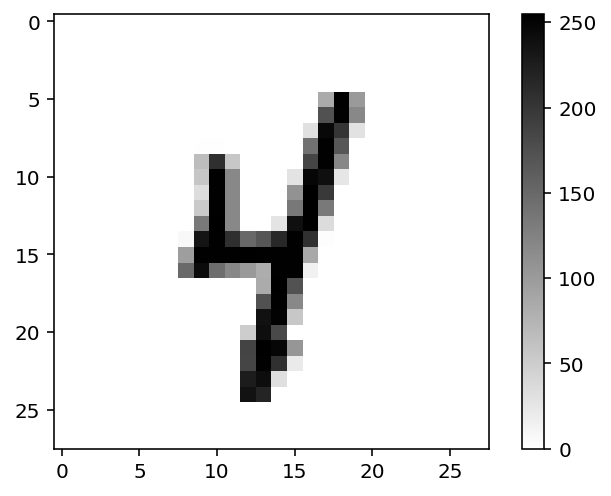

The label of the image is 4


In [9]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze() # 28 x 28 x 1 => 28 x 28
    label = label.numpy()

# plot the image
plt.imshow(image, cmap=plt.cm.binary) # cmap = color map (binary for grayscale)
plt.colorbar()
plt.show()

print('The label of the image is', label)

## Create Pipeline

As we can see, the pixel values of our images are in the range `[0, 255]`. We will now normalize the images and create a pipeline with our training set so that it can be fed into our neural network. In order to normalize the images we are going to divide the pixel values by 255. We will therefore, first change the `dtype` of our image from `uint8` to `float32`  (32-bit single-precision floating-point numbers) using the `tf.cast` function.

In [10]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batch = training_set.cache().shuffle(num_training_examples // 4).batch(batch_size).map(normalize).prefetch(1)

You'll notice we created the pipeline with a batch size of `64`, and that we are shuffling our dataset. The batch size is the number of images we get in one iteration and are passed through our network, often called a *batch*. The `shuffle` transformation randomly shuffles the elements of our dataset before being fed to our network.

Although many of these transformations are commutative, the ordering of certain transformations has performance implications. For more information on these transformations and their impact on performance make sure to check the following links:

* [Pipeline Performance](https://www.tensorflow.org/beta/guide/data_performance)


* [Transformations](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Now that we have our `training_batches` let's inspect them:

In [11]:
for image_batch, label_batch in training_batch.take(1):
    print('Th images in each bath have:')
    print('\u2022 dtype:', image_batch.dtype)
    print('\u2022 shape:', image_batch.shape)

    print('\nThere are a total of {} image labels in this batch'.format(label_batch.numpy().size))
    print(label_batch.numpy())

Th images in each bath have:
• dtype: <dtype: 'float32'>
• shape: (64, 28, 28, 1)

There are a total of 64 image labels in this batch
[0 0 6 9 1 1 6 4 7 9 5 9 0 1 5 0 4 8 7 7 4 2 9 1 4 7 5 1 7 0 0 0 6 5 4 4 9
 5 3 4 2 5 3 2 6 9 1 3 1 1 1 3 6 7 9 8 3 9 7 0 5 1 0 7]


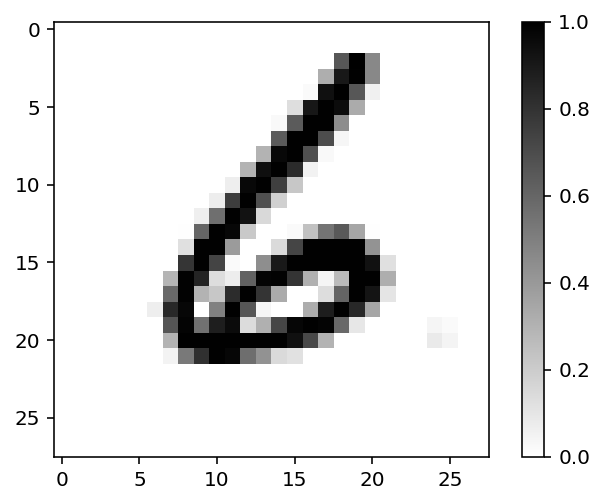

The label of the image is 6


In [12]:
# take a single batch of images, and remove the color dimension by squeezing it
for image_batch, label_batch in training_batch.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

# plot the image
plt.imshow(images[5], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of the image is', labels[5])

## Build a Simple Neural Network

First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications, just like we did in the previous notebook. Then, we'll see how to do it using TensorFlow and Keras, which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28 $\times$ 28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape `(64, 28, 28, 1)` to a have a shape of `(64, 784)`, 784 is 28 times 28. This is typically called *flattening*, we flattened the 2D images into 1D vectors.

In the previous notebook, you built a network with one output unit. Here we need 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do, is calculate the probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

In [23]:
def sigmoid_activation(x):
    return 1 / (1 + tf.exp(-x))

features = tf.reshape(images, [images.shape[0], -1]) # -1 is a special value used to flatten the array

print('The inputs have shape:', features.shape)

n_inputs = features.shape[1]
n_hidden = 256
n_output = 10

input_weights = tf.random.normal([n_inputs, n_hidden])
hidden_weights = tf.random.normal([n_hidden, n_output])

y_hidden = sigmoid_activation(tf.matmul(features, input_weights))
y_output = sigmoid_activation(tf.matmul(y_hidden, hidden_weights))

print('The output has shape:', y_output.shape)



The inputs have shape: (64, 784)
The output has shape: (64, 10)


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the most likely class(es) the image belongs to. Something that looks like this:

<img src='assets/image_distribution.png' width=500px>

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it hasn't seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilities sum up to one.

> **Exercise:** Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor `a` with shape `(64, 10)` and a tensor `b` with shape `(64,)`, doing `a/b` will give you an error because TensorFlow will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is the following: for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need `b` to have a shape of `(64, 1)`. This way TensorFlow will divide the 10 values in each row of `a` by the one value in each row of `b`. Pay attention to how you take the sum as well. You'll need to define the `axis` keyword in `tf.reduce_sum()`. Setting `axis=0` takes the sum across the rows while `axis=1` takes the sum across the columns. You will also need to use the `keepdims` keyword in `tf.reduce_sum()` to make sure the output tensor has the correct shape `(64,1)`.

In [29]:
def softmax(y):
    return tf.exp(y) / tf.reduce_sum(tf.exp(y), axis=1, keepdims=True)

# apply softmax to output
probabilities = softmax(y_output)

print('The probabilities have shape:', probabilities.shape)

sum_all_prob = tf.reduce_sum(probabilities, axis=1).numpy()

for i, prob_sum in enumerate(sum_all_prob):
    print('Sum of probabilities for Image {}: {:.1f}'.format(i+1, prob_sum))


The probabilities have shape: (64, 10)
Sum of probabilities for Image 1: 1.0
Sum of probabilities for Image 2: 1.0
Sum of probabilities for Image 3: 1.0
Sum of probabilities for Image 4: 1.0
Sum of probabilities for Image 5: 1.0
Sum of probabilities for Image 6: 1.0
Sum of probabilities for Image 7: 1.0
Sum of probabilities for Image 8: 1.0
Sum of probabilities for Image 9: 1.0
Sum of probabilities for Image 10: 1.0
Sum of probabilities for Image 11: 1.0
Sum of probabilities for Image 12: 1.0
Sum of probabilities for Image 13: 1.0
Sum of probabilities for Image 14: 1.0
Sum of probabilities for Image 15: 1.0
Sum of probabilities for Image 16: 1.0
Sum of probabilities for Image 17: 1.0
Sum of probabilities for Image 18: 1.0
Sum of probabilities for Image 19: 1.0
Sum of probabilities for Image 20: 1.0
Sum of probabilities for Image 21: 1.0
Sum of probabilities for Image 22: 1.0
Sum of probabilities for Image 23: 1.0
Sum of probabilities for Image 24: 1.0
Sum of probabilities for Image 25:

## Building Neural Networks with TensorFlow and Keras

Keras is a high-level API to build and train neural networks. `tf.keras` is TensorFlow's implementation of the Keras API. In Keras, deep learning models are constructed by connecting configurable building blocks called **layers**. The most common type of model is a stack of layers called a **Sequential** model. The model is called sequential because it allows a tensor to be passed sequentially through the operations in each layer. In TensorFlow, the sequential model is implemented with `tf.keras.Sequential`. 

In the cell below, we will use a Keras sequential model to build the same fully-connected neural network that we built in the previous section. Our sequential model will have three layers:

* **Input Layer:** `tf.keras.layers.Flatten` — This layer flattens the images by transforming a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels (28 $\times$ 28 = 784). The first layer in a Sequential model needs to know the shape of the input tensors to the model. Since, this is our first layer, we need to specify the shape of our input tensors using the `input_shape` argument. The `input_shape` is specified using a tuple that contains the size of our images and the number of color channels. It is important to note that we don't have to include the batch size in the tuple. The tuple can have integers or `None` entries, where `None` entries indicate that any positive integer may be expected.

* **Hidden Layer:** `tf.keras.layers.Dense` — A fully-connected (also known as densely connected) layer. For this layer we need to specify the number of neurons (or nodes) we want to use and the activation function. Note that we don't have to specify the shape of the input tensor to this layer, since Keras performs automatic shape inference for all layers except for the first layer. In this particular case, we are going to use `256` neurons with a `sigmoid` activation fucntion. 

* **Output Layer:** `tf.keras.layers.Dense` — A fully-connected layer with 10 neurons and a *softmax* activation function. The output values will represent the probability that the image is a particular digit. The sum of all the 10 nodes values is 1.

In [31]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
# model.add(tf.keras.layers.Dense(n_hidden, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(n_output, activation='softmax'))

model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)),
        tf.keras.layers.Dense(256, activation = 'sigmoid'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


### Your Turn to Build a Neural Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with 10 units and a softmax activation function. You can use a ReLU activation function by setting `activation = 'relu'`.

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_output, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Activation Functions

So far we've only been looking at the softmax activation, but in general any function can be used as an activation function. The only requirement is that for a network to approximate a non-linear function, the activation functions must be non-linear. Here are a few more examples of common activation functions: Tanh (hyperbolic tangent), and ReLU (rectified linear unit).

<img src="assets/activation.png" width=700px>

In practice, the ReLU function is used almost exclusively as the activation function for hidden layers.

## Looking at the Weights and Biases

Keras automatically initializes the weights and biases. The weights and biases are tensors attached to each of the layers you defined in your model. We can get all the weights and biases from our model by using the `get_weights` method. The `get_weights` method returns a list of all the weight and bias tensors in our model as NumPy arrays.